# FFDI CODE: FINAL

All FFDI code in this section was re-run for the later time period (where start_year and end_year were changed)
The outputs of FFDI 1979-1998 and FFDI 2005-2024 were saved as netcdf files
(WARNING: they took about 2.5hrs each to run, on max storage)

## Packages

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import logging
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Preprocessing

In [4]:
# Largely courtesy of Dr Rachael Isphording

In [2]:
# Define bounding box (SWWA)
lat_slice = slice(-36, -32)     
lon_slice = slice(114, 118)

barra11_land_mask = xr.open_dataset('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/sftlf/latest/sftlf_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc')
mask = barra11_land_mask['sftlf'].sel(lat=lat_slice, lon=lon_slice)
land_mask = mask > 0

In [3]:
def load_barra_files(path, start_year, end_year, var, 
                     lon_slice=None, lat_slice=None):
    # load land mask
    mask_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/sftlf/latest/sftlf_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc"
    land_mask = xr.open_dataset(mask_path)['sftlf']

    if lon_slice and lat_slice:
        land_mask = land_mask.sel(lon=lon_slice, lat=lat_slice)

    land_mask_bool = land_mask >= 50  # boolean mask, 50% of the grid cell or more must be land

    # find files
    all_files = sorted(glob.glob(os.path.join(path, f"{var}_*.nc")))
    
    filtered_files = []
    for f in all_files:
        fname_year = int(os.path.basename(f).split('_')[-1].split('-')[0][:4])
        if start_year <= fname_year <= end_year:
            filtered_files.append(f)
    
    print(f"Found {len(filtered_files)} files for {start_year}-{end_year} in {path}")
    
    # define preprocessing
    def preprocess(ds):
        if lon_slice and lat_slice:
            ds = ds.sel(lon=lon_slice, lat=lat_slice)
        ds[var] = ds[var].where(land_mask_bool) # apply mask
        return ds

    # open files
    ds = xr.open_mfdataset(
        filtered_files,
        combine='by_coords',
        preprocess=preprocess,
        chunks={'time': 365, 'lat': 20, 'lon': 20},  # tweak chunk size for performance
        parallel=True,
    )

    return ds

# Keetch-Byram Drought Index (KBDI)

## KBDI: Precipitation

In [8]:
# LOAD DATA:
# set-up BARRA path and variable
barra_pr_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/latest"
start_year = 1979
end_year = 1998
variable = "pr"

# load BARRA precipitation data for SWWA
barra_aus11_pr = load_barra_files(barra_pr_path, start_year, end_year, variable,
                                   lat_slice=lat_slice, lon_slice=lon_slice)

Found 240 files for 1979-1998 in /g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/latest


In [10]:
precip_mm_day = barra_aus11_pr['pr'] * 86400  # convert to mm/day (BARRA is inkg/m²/s) 
# print(precip_mm_day.head()) # check attributes

In [11]:
# Calculating adjusted rainfall as per Keetch & Bryam (1968)

# define threshold (mm)
threshold = 5.08

def adjusted_rainfall(pr, threshold=5.08):
    # make a copy for output
    adj = pr.copy(deep=True)
    adj[:] = 0  # initialise everything to zero
    
    # convert to numpy for speed (still 3D: time, lat, lon)
    rain = pr.values
    out = np.zeros_like(rain)
    
    # keep cumulative totals for all grid cells at once
    cumulative = np.zeros_like(rain[0])
    active = np.zeros_like(rain[0], dtype=bool)  # whether it's in 'post-threshold' or not
    
    for t in range(rain.shape[0]):
        if not np.all(active):
            cumulative[~active] += rain[t, ~active]
        
        # if threshold is exceeded (and wasn't active before)
        just_activated = (~active) & (cumulative > threshold)
        out[t, just_activated] = cumulative[just_activated] - threshold
        active |= just_activated
        
        # days after threshold is exceeded & rain > 0
        raining_after = active & (rain[t] > 0) & ~just_activated
        out[t, raining_after] = rain[t, raining_after]
        
        # if rain = 0, reset
        reset_cells = (active & (rain[t] == 0))
        active[reset_cells] = False
        cumulative[reset_cells] = 0

    # convert back to DataArray
    adj[:] = out
    adj.name = "adjusted_rainfall"
    adj.attrs["units"] = pr.attrs.get("units", "mm/day")
    adj.attrs["description"] = f"Daily adjusted rainfall after threshold {threshold} mm"
    
    return adj

In [27]:
adjust_rain_test = adjusted_rainfall(precip_mm_day,threshold)
#cell takes a while to run!

In [28]:
adjust_rain_test.compute().max()#.isel(time=0).plot()

# taking largest value for the day & computing it

adjust_rain = adjust_rain_test.compute()

## KBDI: Temperature

In [12]:
# set up BARRA path and variable (years previously defined)
barra_temp_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmax/latest"
variable_temp = "tasmax" # maximum temp for that day

# load BARRA precipitation data for SWWA
barra_aus11_temp = load_barra_files(barra_temp_path, start_year, end_year, variable_temp,
                                   lat_slice=lat_slice, lon_slice=lon_slice)

Found 240 files for 1979-1998 in /g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tasmax/latest


In [13]:
temp_C = barra_aus11_temp['tasmax'] - 273.15 # convert K to C

# temp_C.isel(time=6190).plot() # sense check

In [32]:
#temp_C.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/temp_new.nc")

## KBDI: Evapotranspiration (ET) & KBDI calculation

In [26]:
# ET calculation from Keetch & Byram
def calculate_ET(prev_KBDI, temp_C, mean_annual_rainfall):
    numerator = (203.2 - prev_KBDI) * (0.968 * np.exp(0.0875 * temp_C + 1.5552) - 8.30)
    denominator = 1 + 10.88 * np.exp(-0.001736 * mean_annual_rainfall)
    ET = 0.001 * (numerator / denominator)
    return ET

# recursive daily KBDI calculation for a single time series
def kbdi_timeseries(tmax, precip, mean_annual_rainfall, initial_kbdi=50.0):
    # inputs: tmax (daily max temp,°C), precip (daily rainfall, mm), mean_annual_rainfall (mm/year for this grid cell), initial_kbdi (mm) 
    n = len(tmax)
    kbdi = np.zeros(n, dtype=np.float64)
    kbdi[0] = initial_kbdi

    for i in range(1, n):
        prev_KBDI = kbdi[i-1]

        # ET uses yesterday's conditions
        ET = calculate_ET(prev_KBDI, tmax[i-1], mean_annual_rainfall)

        # Net rainfall = max(0, rain - 5)
        net_rain = max(0, precip[i-1] - 5.0)

        # update new KBDI
        new_KBDI = prev_KBDI + ET - net_rain

        # between 0 and 203.2
        new_KBDI = min(max(new_KBDI, 0), 203.2)

        kbdi[i] = new_KBDI

    return kbdi

# make sure time is one chunk (whole series together)
temp_C = temp_C.chunk(dict(time=-1))
adjust_rain = adjust_rain.chunk(dict(time=-1))

def compute_kbdi(ds, initial_kbdi=50.0):
    # tasmax & adjust_rain now in time,lat,lon (not 1D)
    # mean annual rainfall per grid cell (mm/year):
    annual_rain = ds['adjust_rain'].resample(time="YE").sum(dim="time")
    mean_annual_rain = annual_rain.mean(dim="time")  # (lat, lon)

    # run recursive timeseries across all grid cells
    kbdi = xr.apply_ufunc(
        kbdi_timeseries,
        ds["temp_C"],
        ds["adjust_rain"],
        mean_annual_rain,
        kwargs={"initial_kbdi": initial_kbdi},
        input_core_dims=[["time"], ["time"], []],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    kbdi.name = "kbdi"
    return kbdi

In [27]:
# temp_C : (time, lat, lon) daily max temperature in °C
# adjust_rain : (time, lat, lon) daily rainfall in mm/day

# combine into a dataset
ds = xr.Dataset({
    "temp_C": temp_C,
    "adjust_rain": adjust_rain
})

# run KBDI calculation
kbdi = compute_kbdi(ds, initial_kbdi=50.0)

# attach result
ds["kbdi"] = kbdi

# save to NetCDF (only do this once!)
#ds[["kbdi"]].to_netcdf("KBDI_output.nc")

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


In [29]:
kbdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/KBDI_old.nc")

## Griffiths' Drought Factor (DF)

In [29]:
# added in, so dont have to reload kbdi 

# KBDI: 2005-2024
kbdi_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/KBDI_old.nc')
kbdi = kbdi_var_old["kbdi"]

In [19]:
# using Finkele 2006 & Lucas 2010 (eqn from BOM doc, error in griffiths 1999)

In [30]:
def _sig_rain_event(rain, window=20):
    out = np.ones_like(rain, dtype=float)

    for t in range(len(rain)):
        start = max(0, t - window + 1)
        window_rain = rain[start:t+1].copy()
            
        #split the window into events, where each event is n consecutive days of rain, minimum 1 day.
        locs = np.array(np.where(window_rain > 2))[0] #location where days above 2 mm
         # if locs is empty then set so we don't compute P or N and move on
        if np.size(locs) > 0:
            breaks = np.where(np.diff(locs)>1)[0]+1 #splits at the time where the difference in location is more than 1 day
            group = np.split(locs, breaks) #groups the data by the breaks between events
            Ps = [window_rain[g].sum() for g in group] #sums over the groups
            Ns = [len(window_rain) - (g[0] + np.argmax(window_rain[g])) - 1 for g in group]

            # maximise the value for the biggest rain event using the following conditions as outlined in the paper
            tmpx = np.zeros(len(Ps))
            for i in range(len(Ps)):
                # apply piecewise x equation
              N = Ns[i]
              P = Ps[i]
              if (N >= 1) and (P > 2):
                tmpx[i] = (N**1.3) / (N**1.3 + (P - 2))
              elif (N == 0) and (P > 2):
                tmpx[i] = (0.8**1.3) / (0.8**1.3 + (P - 2))
              else:
                tmpx[i] = 1.0
          
            out[t] = np.max(tmpx)
        
        else: out[t] = 1.0
 
    return out

In [31]:
def calculate_sig_rain_event(rain, window=20):
    x = xr.apply_ufunc(
        _sig_rain_event,
        rain,
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,                # loop over lat/lon
        dask="parallelized",           # allow dask execution
        output_dtypes=[float],
        kwargs={"window": window}
    )
    return x

In [32]:
def calculate_x_lim(kbdi):
    return xr.where(kbdi < 20,
                    1 / (1 + 0.1135 * kbdi),
                    75 / (270.525 - 1.267 * kbdi))

def calculate_drought_factor(kbdi_test, rain, window=20):
    x_event = calculate_sig_rain_event(rain, window=window)
    x_lim = calculate_x_lim(kbdi_test)
    x = xr.where(x_event < x_lim, x_event, x_lim)

    x_term = (41 * x**2 + x) / (40 * x**2 + x + 1)
    kbdi_term = 10.5 * (1 - np.exp(-(kbdi_test + 30) / 40.0))
    df = kbdi_term * x_term
    return xr.where(df > 10, 10, df)

In [33]:
precip_mm_day = precip_mm_day.chunk({"time": -1})  # put all time into one chunk
df = calculate_drought_factor(kbdi, precip_mm_day)

In [35]:
df.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/df_old.nc")

## Windspeed (3pm)

In [2]:
# windspeed = np.sqrt(u**2 + v**2), 
# u is eastward near surface wind (use hourly instantaneous, FFDI usually at 3pm so adjust for UTC. it will be one day out)
# v is northward 
# both are positive, usually m/s (check)

# u = uas (hourly instant), v = vas (hourly instant), select for 3pm 

In [35]:
# THIS IS FOR UAS
barra_uas_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/uas/latest"
variable_uas = "uas"

# Load BARRA precipitation data for subregion
barra_aus11_uas = load_barra_files(barra_uas_path, start_year, end_year, variable_uas,
                                   lat_slice=lat_slice, lon_slice=lon_slice)

Found 240 files for 1979-1998 in /g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/uas/latest


In [36]:
# THIS IS FOR VAS
barra_vas_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/vas/latest"
variable_vas = "vas"

# Load BARRA precipitation data for subregion
barra_aus11_vas = load_barra_files(barra_vas_path, start_year, end_year, variable_vas,
                                   lat_slice=lat_slice, lon_slice=lon_slice)

Found 240 files for 1979-1998 in /g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/vas/latest


In [37]:
# Select 07 UTC (which is 3pm Perth)
uas_3pm = barra_aus11_uas.sel(time=barra_aus11_uas.time.dt.hour == 7)
vas_3pm = barra_aus11_vas.sel(time=barra_aus11_vas.time.dt.hour == 7)

# calculate windspeed lazily (otherwise its too computationally massive)
windspeed = np.sqrt(uas_3pm["uas"]**2 + vas_3pm["vas"]**2)

In [28]:
wind_units = xr.open_dataset('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/uas/latest/uas_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_197902-197902.nc')

In [38]:
windspeed_nc = windspeed * 3.6 (m/s to km/h)

In [39]:
windspeed_nc.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/windspeed_old.nc")

## Relative Humidity (3pm)

In [14]:
barra_hurs_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/hurs/latest"
variable_hurs= "hurs"

# Load BARRA precipitation data for SWWA
barra_aus11_hurs = load_barra_files(barra_hurs_path, start_year, end_year, variable_hurs,
                                   lat_slice=lat_slice, lon_slice=lon_slice)

Found 240 files for 1979-1998 in /g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/hurs/latest


In [15]:
# Select 07 UTC (which is 3pm Perth)
hurs_3pm = barra_aus11_hurs["hurs"].sel(time=barra_aus11_hurs.time.dt.hour == 7)

In [7]:
hurs_3pm.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/rh_new.nc")

# FFDI Calculation

In [22]:
temp_test = temp_C.compute()

# calling temp

In [23]:
# grab variables
temp = temp_test
df = df     # from Griffiths function earlier
rh = hurs_3pm                # relative humidity at 3 pm (%)
wind = windspeed          # wind speed at 10m (km/h)

# strip hours from the 3pm variables so they align with daily datasets (was giving a blank map bc NANs and didnt align by time)
rh = rh.copy()
rh["time"] = rh["time"].dt.floor("D")

wind = wind.copy()
wind["time"] = wind["time"].dt.floor("D")

temp = temp.copy()
temp["time"] = temp["time"].dt.floor("D")

df = df.copy()
df["time"] = df["time"].dt.floor("D")

In [24]:
# avoid log(0) by forcing a minimum drought factor of 1
df_safe = df.clip(min=1)

ffdi = 2 * np.exp(
    -0.45 +
    0.987 * np.log(df_safe) +
    -0.0345 * rh +
    0.0338 * temp +
    0.0234 * (wind * 3.6)   # convert m/s → km/h (assuming your using this code, not previously made netcdf, otherwise conversion is doubles up)
)

# Saving the FFDI files

In [4]:
#ffdi.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI.nc") # 2005-2024

In [6]:
#ffdi_old.to_netcdf("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI_old.nc") # 197

In [7]:
ffdi_nc_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI_old.nc')

ffdi_nc_old["ffdi"] = ffdi_nc_old["__xarray_dataarray_variable__"]

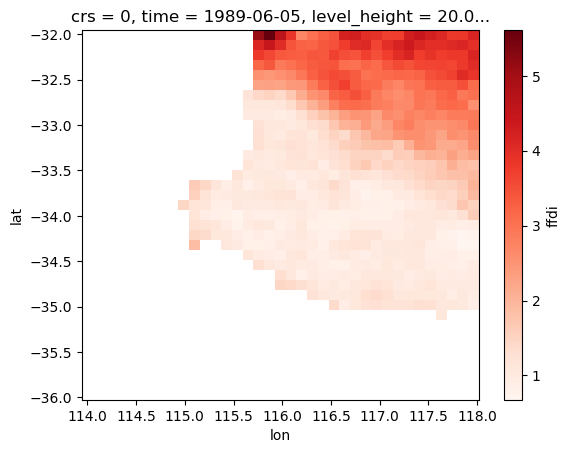

In [8]:
ffdi_var_old = ffdi_nc_old["ffdi"]  # select the variable as a DataArray
ffdi_point_old = ffdi_var_old.sel(time="1989-06-05")
ffdi_point_old.plot(x="lon", y="lat", cmap="Reds")

In [13]:
# --- Select February for each period ---
ffdi_feb_1 = ffdi_var_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=ffdi_var_old['time'].dt.month == 2)
ffdi_feb_2 = ffdi_var.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=ffdi_var['time'].dt.month == 2)

# --- Apply threshold mask (FFDI > 50) ---
ffdi_feb_1_50 = ffdi_feb_1 > 50
ffdi_feb_2_50 = ffdi_feb_2 > 50

# --- Count extreme days at each gridcell ---
freq_1 = ffdi_feb_1_50.sum(dim="time")
freq_2 = ffdi_feb_2_50.sum(dim="time")

# --- Difference in counts ---
diff_freq = freq_1 - freq_2

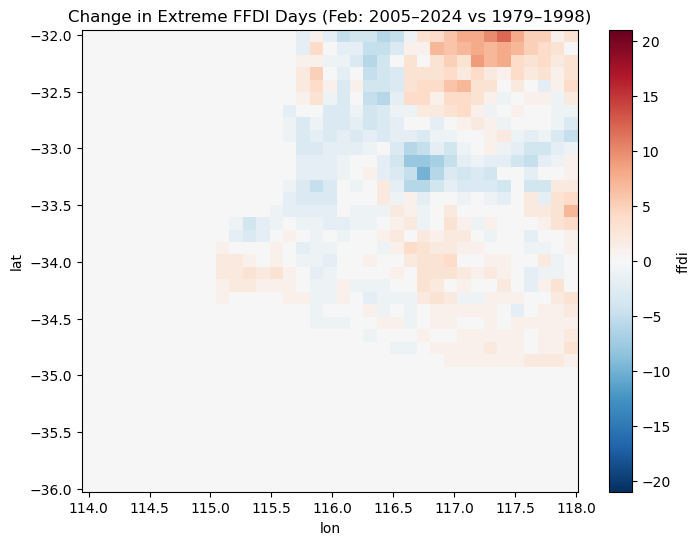

In [14]:
plt.figure(figsize=(8,6))
diff_freq.plot(x='lon', y='lat', cmap="RdBu_r", vmin=-freq_2.max(), vmax=freq_2.max())
plt.title("Change in Extreme FFDI Days (Feb: 2005–2024 vs 1979–1998)")
plt.show()

/jobfs/149072418.gadi-pbs/ipykernel_4008914/1135523565.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


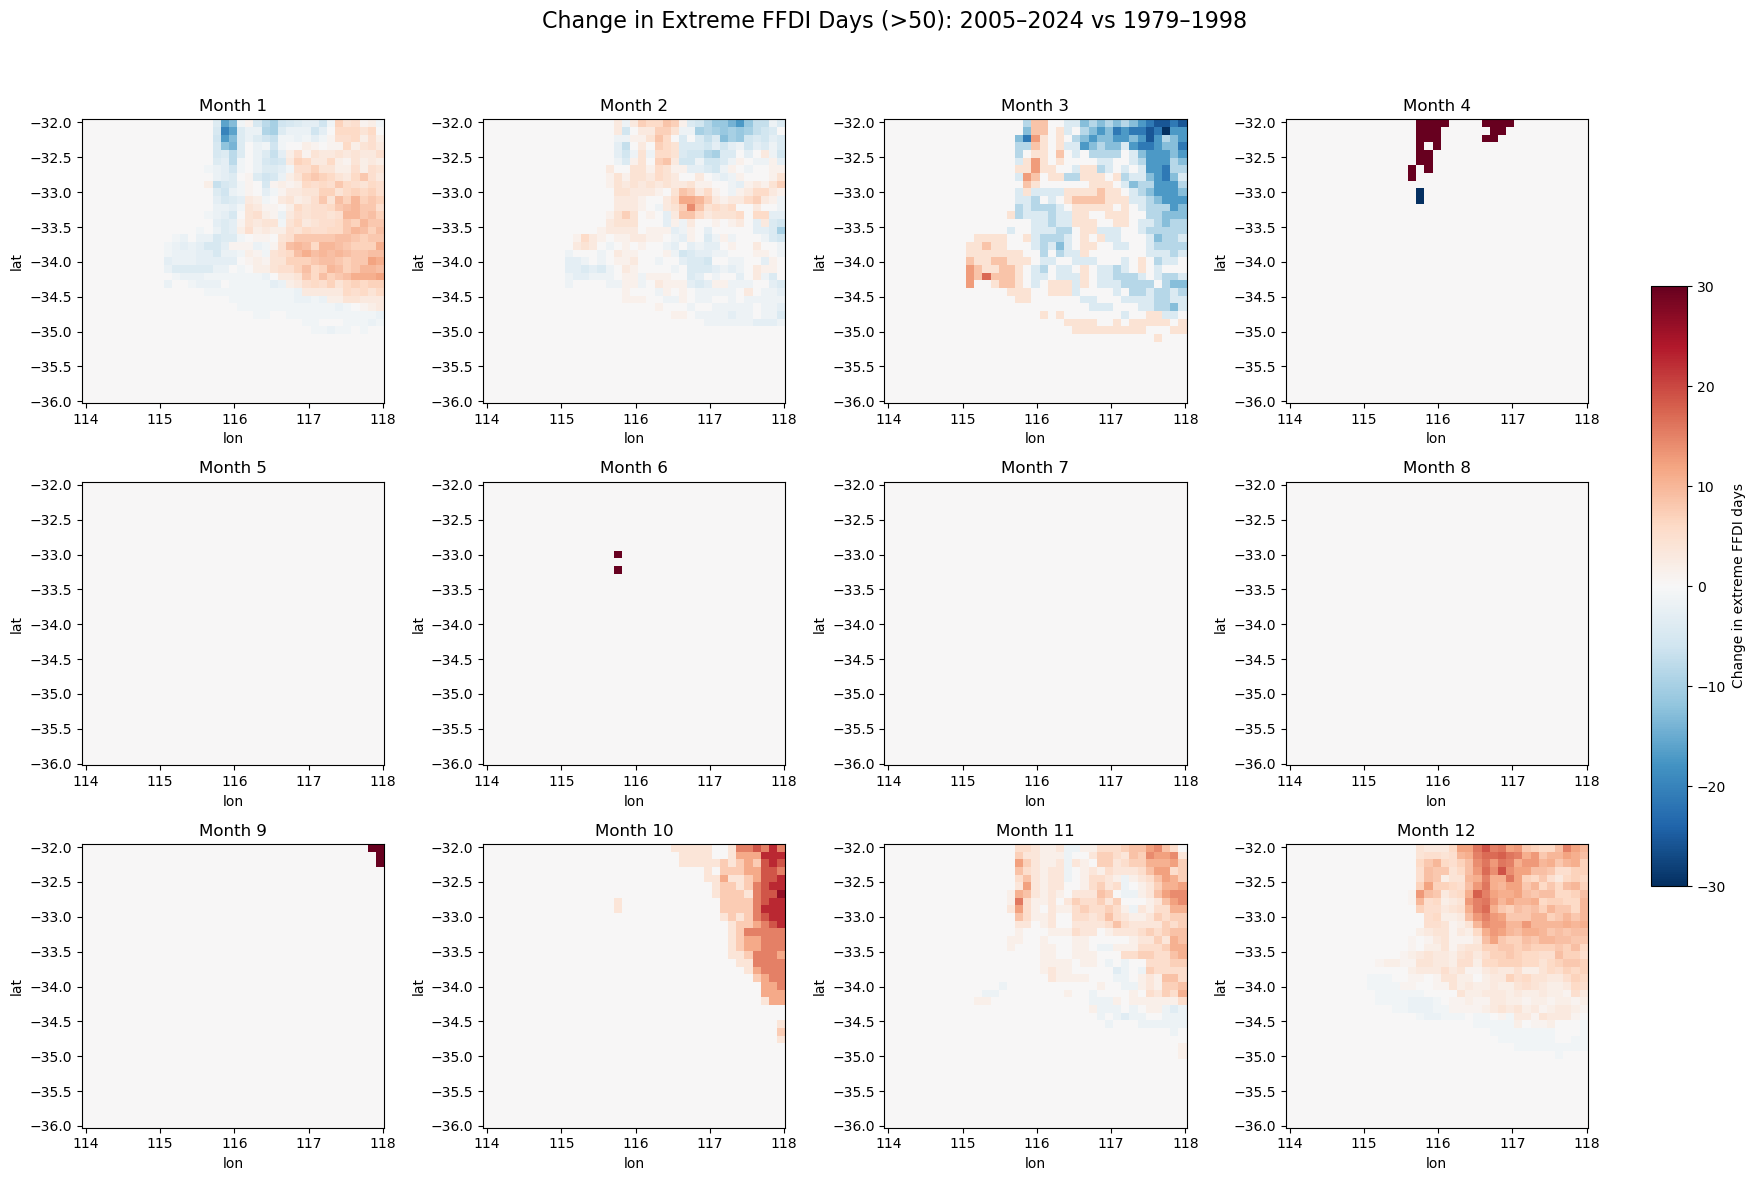

In [21]:
# --- Create figure with 12 subplots (3 rows x 4 cols) ---
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'projection': None})
axes = axes.flatten()

for m in range(1, 13):
    # --- Select month m for each period ---
    ffdi_m1 = ffdi_var_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=ffdi_var_old['time'].dt.month == m)
    ffdi_m2 = ffdi_var.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=ffdi_var['time'].dt.month == m)

    # --- Apply threshold mask ---
    ffdi_m1_50 = ffdi_m1 > 50
    ffdi_m2_50 = ffdi_m2 > 50

    # --- Count extreme days ---
    freq1 = ffdi_m1_50.sum(dim="time")
    freq2 = ffdi_m2_50.sum(dim="time")

    # --- Difference (new minus old) ---
    diff = freq2 - freq1   # I flipped to new-old since your title suggested "2005–2024 vs 1979–1998"

    # --- Plot ---
    im = diff.plot(
        ax=axes[m-1],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-freq2.max().item(), vmax=freq2.max().item()
    )
    axes[m-1].set_title(f"Month {m}")

# --- Add shared colorbar ---
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label="Change in extreme FFDI days")

plt.suptitle("Change in Extreme FFDI Days (>50): 2005–2024 vs 1979–1998", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()



In [17]:
# T test timeeee


from scipy.stats import ttest_ind

In [31]:
# example for feb

# --- Apply t-test across time dimension ---
def ttest_func(a, b):
    # a, b are 1D arrays (time), one per grid cell
    stat, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
    return p


# Convert to float before t-test (wasnt letting me run p on the xarray)
ffdi_feb_1_50_float = ffdi_feb_1_50.astype(float)
ffdi_feb_2_50_float = ffdi_feb_2_50.astype(float)

# --- Apply t-test across time dimension ---
def ttest_func(a, b):
    stat, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
    return p

pvals = xr.apply_ufunc(
    ttest_func,
    ffdi_feb_1_50_float,
    ffdi_feb_2_50_float,
    input_core_dims=[["time"], ["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
    join="override"   # important so time coords don’t need to match
)


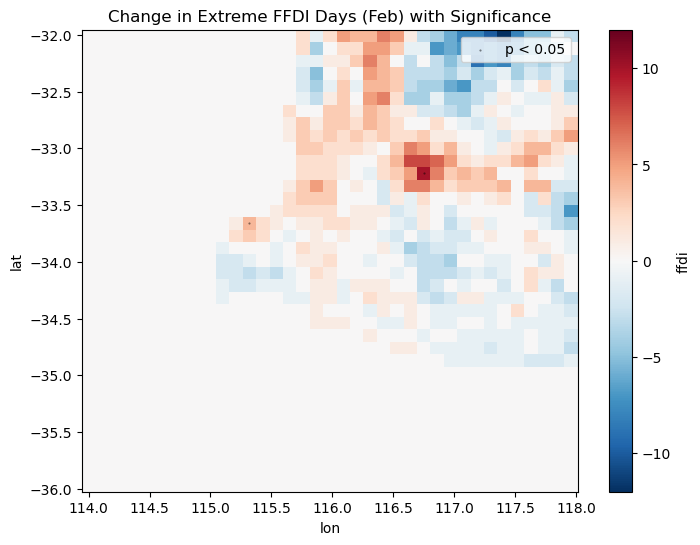

In [40]:
# --- Difference (counts) ---
freq1_feb = ffdi_feb_1_50_float.sum(dim="time")
freq2_feb = ffdi_feb_2_50_float.sum(dim="time")
diff_feb = freq2 - freq1

# --- Plot with stippling where p < 0.05 ---
plt.figure(figsize=(8,6))
im = diff.plot(x='lon', y='lat', cmap="RdBu_r")
plt.title("Change in Extreme FFDI Days (Feb) with Significance")

# --- significance mask ---
sig = (pvals < 0.05)

# --- lat/lon meshgrid ---
lon2d, lat2d = np.meshgrid(diff['lon'].values, diff['lat'].values)

# --- scatter only significant points ---
plt.scatter(
    lon2d[sig.values],
    lat2d[sig.values],
    c="k",
    s=1,
    alpha=0.5,
    marker=".",
    label="p < 0.05",
    zorder=2,
)

plt.legend()
plt.show()

/jobfs/149072418.gadi-pbs/ipykernel_4008914/3095832231.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


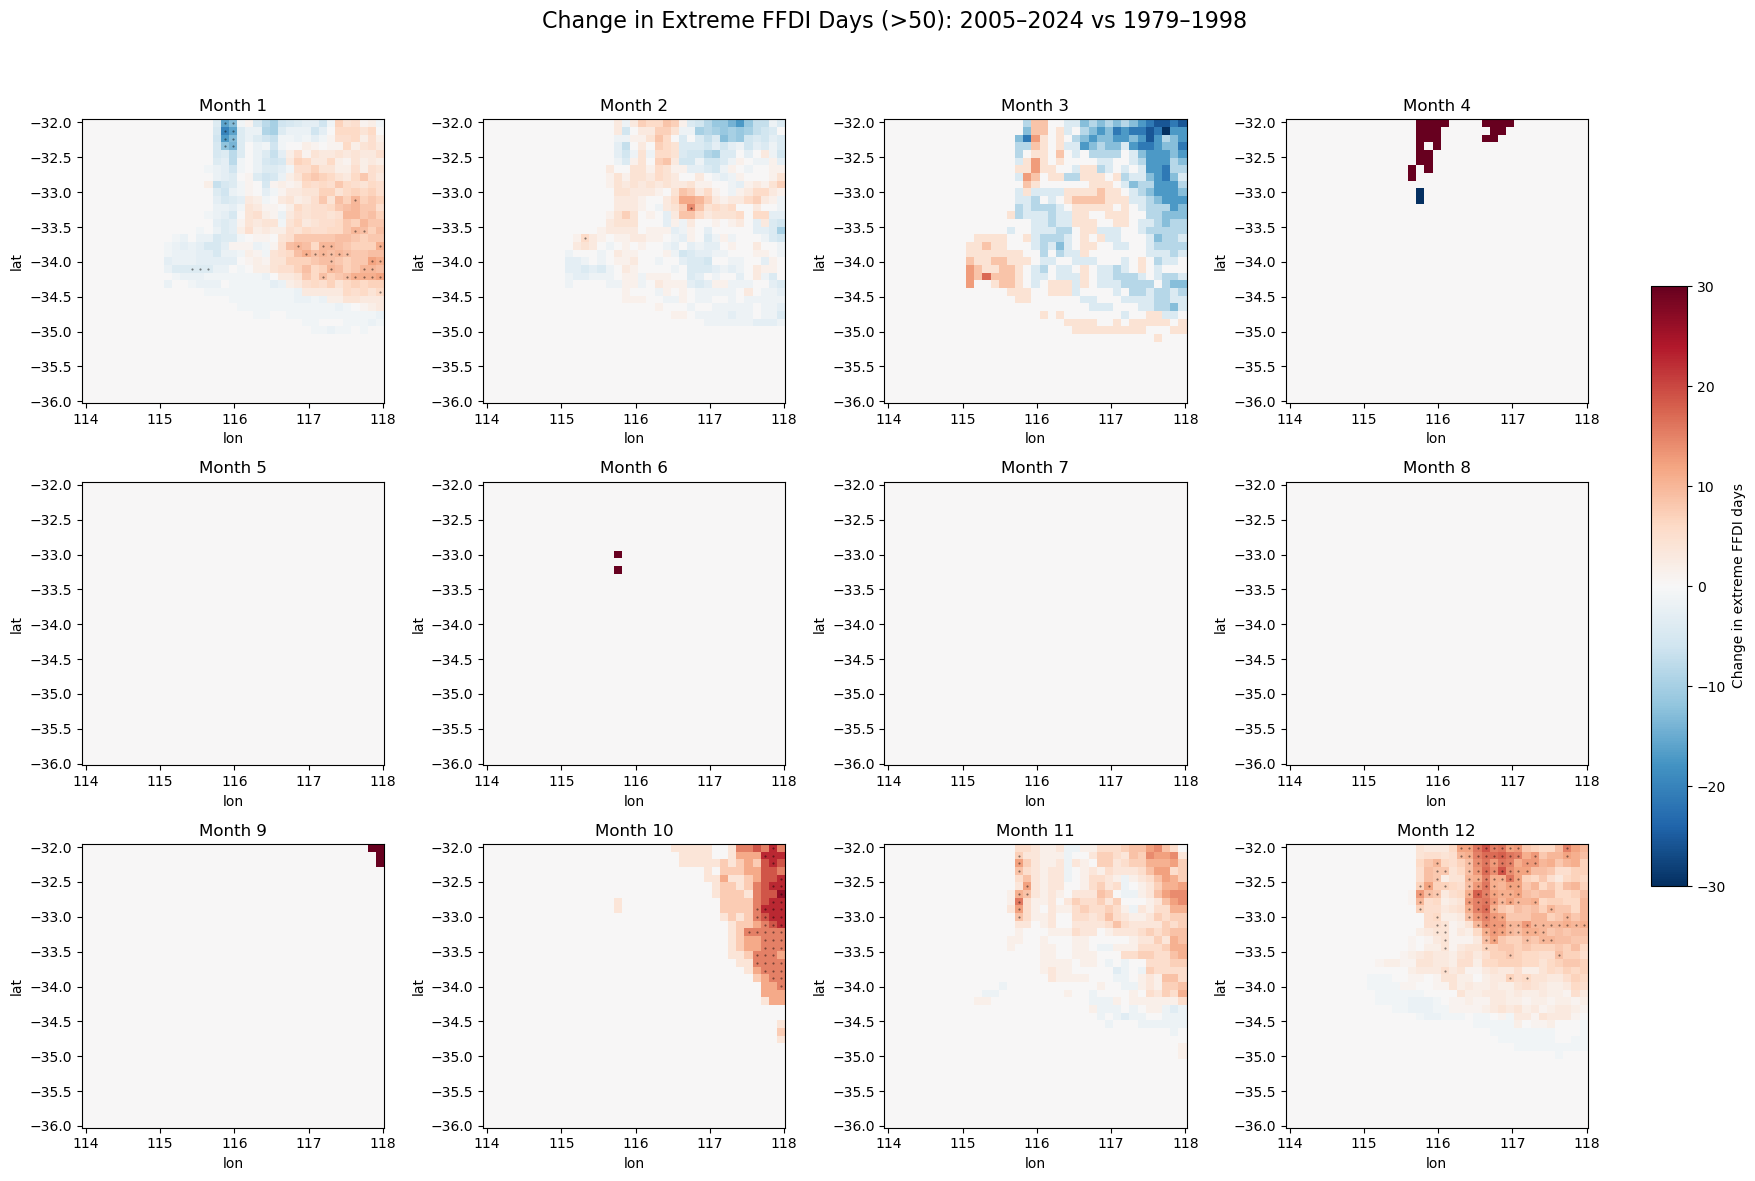

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import ttest_ind

# --- Create figure with 12 subplots (3 rows x 4 cols) ---
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for m in range(1, 13):
    # --- Select month m for each period ---
    ffdi_m1 = ffdi_var_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=ffdi_var_old['time'].dt.month == m)
    ffdi_m2 = ffdi_var.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=ffdi_var['time'].dt.month == m)

    # --- Apply threshold mask (>50) and convert to float ---
    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    # --- Count extreme days ---
    freq1 = ffdi_m1_50.sum(dim="time")
    freq2 = ffdi_m2_50.sum(dim="time")
    diff = freq2 - freq1   # change in number of extreme days

    # --- Welch’s t-test across time dimension ---
    def ttest_func(a, b):
        stat, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
        return p

    pvals = xr.apply_ufunc(
        ttest_func,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # --- Plot map ---
    im = diff.plot(
        ax=axes[m-1],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-freq2.max().item(),
        vmax=freq2.max().item()
    )
    axes[m-1].set_title(
        xr.coding.cftime_offsets.get_date_type(ffdi_var['time'].dt.to_pandas().iloc[0]).strftime("%B")
        if hasattr(ffdi_var['time'].dt, "to_pandas") else f"Month {m}"
    )

    # --- Stippling where significant (p < 0.05) ---
    sig = (pvals < 0.05)
    lon2d, lat2d = np.meshgrid(diff['lon'].values, diff['lat'].values)
    axes[m-1].scatter(
        lon2d[sig.values],
        lat2d[sig.values],
        c="k",
        s=1,
        alpha=0.5,
        marker=".",
        zorder=2,
    )

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, label="Change in extreme FFDI days")

plt.suptitle("Change in Extreme FFDI Days (>50): 2005–2024 vs 1979–1998", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


/jobfs/149072418.gadi-pbs/ipykernel_4008914/3584834396.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


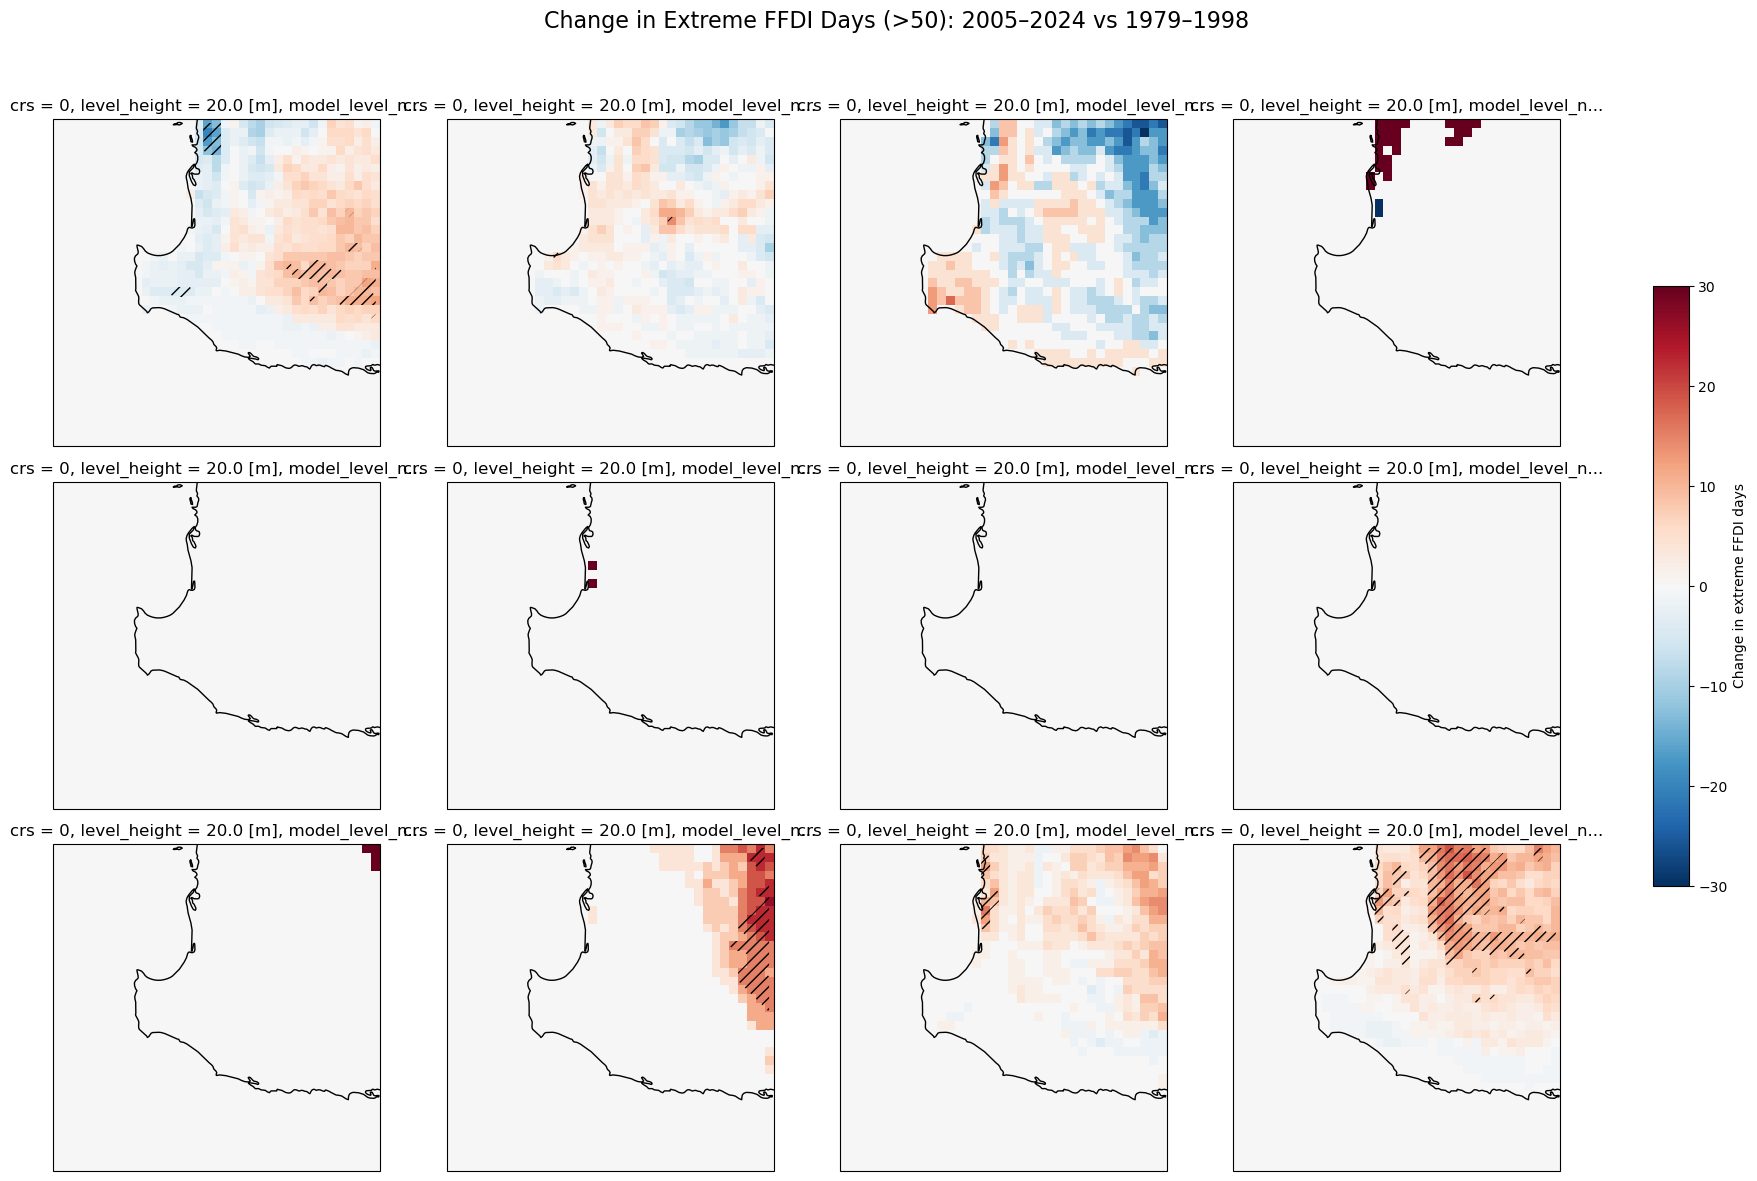

In [47]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for m in range(1, 13):
    ffdi_m1 = ffdi_var_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=ffdi_var_old['time'].dt.month == m)
    ffdi_m2 = ffdi_var.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=ffdi_var['time'].dt.month == m)

    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    freq1 = ffdi_m1_50.sum(dim="time")
    freq2 = ffdi_m2_50.sum(dim="time")
    diff = freq2 - freq1

    def ttest_func(a, b):
        stat, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
        return p

    # welch t-test!! unequal var

    pvals = xr.apply_ufunc(
        ttest_func,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # --- Plot map ---
    im = diff.plot(
        ax=axes[m-1],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-freq2.max().item(),
        vmax=freq2.max().item()
    )

    # --- Add coastlines and land ---
    axes[m-1].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[m-1].add_feature(cfeature.LAND, facecolor="lightgrey")

    # --- Stippling ---
    # --- Hatching instead of dots ---
    sig = (pvals < 0.05)

    # Use contourf with alpha=0 to keep original colormap visible
    axes[m-1].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],       # contours only where sig is True
        colors='none',         # transparent
        hatches=['///'],       # hatching pattern
        transform=ccrs.PlateCarree(),
        alpha=0
    )
  

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, label="Change in extreme FFDI days")

plt.suptitle("Change in Extreme FFDI Days (>50): 2005–2024 vs 1979–1998", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)
fig.savefig(
    "/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/QUESTION1/changes_50.png",
    dpi=600,
    bbox_inches='tight'
)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


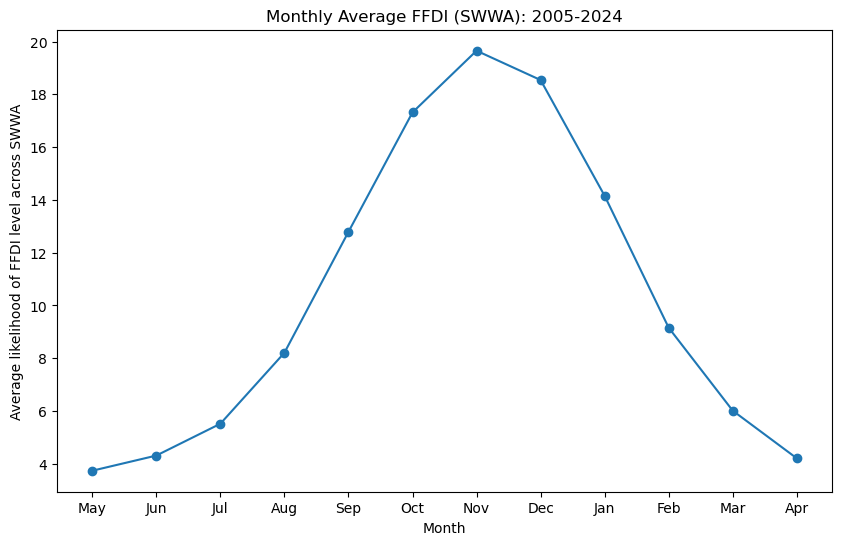

In [51]:
import calendar
import matplotlib.pyplot as plt

# --- Spatial + monthly average ---
ffdi_avg = ffdi_nc["ffdi"].mean(dim=("lat", "lon"))
ffdi_avg_month = ffdi_avg.groupby("time.month").mean("time")

# --- Shift to start at May ---
ffdi_avg_month_shifted = ffdi_avg_month.roll(month=-6, roll_coords=False)

# --- Plot ---
plt.figure(figsize=(10,6))
ffdi_avg_month_shifted.plot(marker="o")

# Replace ticks with month names
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in ffdi_avg_month_shifted["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[(i+4)%12+1] for i in range(12)])


plt.ylabel("Average likelihood of FFDI level across SWWA")
plt.xlabel("Month")
plt.title("Monthly Average FFDI (SWWA): 2005-2024")
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


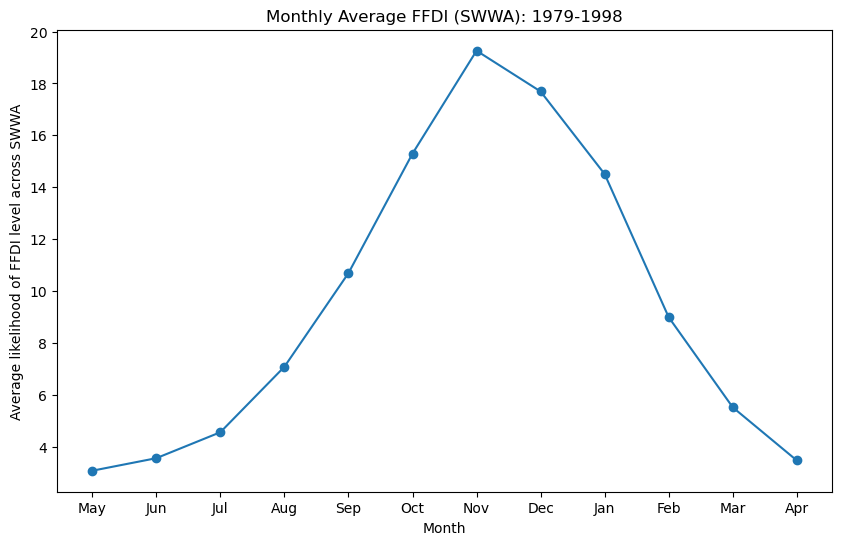

In [53]:
# --- Spatial + monthly average ---
ffdi_avg = ffdi_nc_old["ffdi"].mean(dim=("lat", "lon"))
ffdi_avg_month = ffdi_avg.groupby("time.month").mean("time")

# --- Shift to start at May ---
ffdi_avg_month_shifted = ffdi_avg_month.roll(month=-6, roll_coords=False)

# --- Plot ---
plt.figure(figsize=(10,6))
ffdi_avg_month_shifted.plot(marker="o")

# Replace ticks with month names
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in ffdi_avg_month_shifted["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[(i+4)%12+1] for i in range(12)])


plt.ylabel("Average likelihood of FFDI level across SWWA")
plt.xlabel("Month")
plt.title("Monthly Average FFDI (SWWA): 1979-1998")
plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


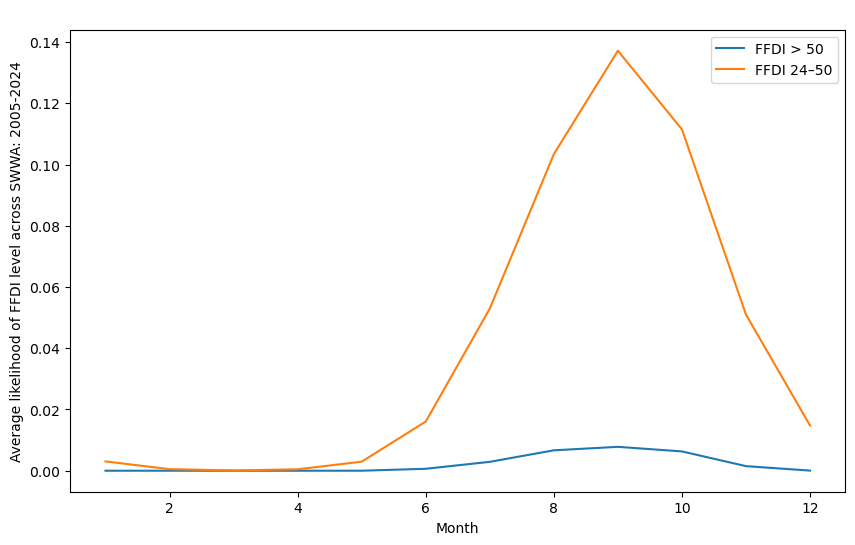

<Figure size 640x480 with 0 Axes>

In [55]:
# Threshold mask
ffdi_50 = ffdi_nc["ffdi"] > 50
ffdi_vh = (ffdi_nc["ffdi"] >= 24) & (ffdi_nc["ffdi"] <= 50)

# Spatial mean (likelihood across the region for each day)
ffdi_swwa_mean = ffdi_50.mean(dim=("lat", "lon"))
ffdi_vh_mean = ffdi_vh.mean(dim=("lat", "lon"))

# --- Shift to start at May ---
ffdi_avg_month_50 = ffdi_swwa_mean.groupby("time.month").mean("time")
clim_50 = ffdi_avg_month_50.roll(month=-4, roll_coords=False)

ffdi_avg_month_24 = ffdi_vh_mean.groupby("time.month").mean("time")
clim_24 = ffdi_avg_month_24.roll(month=-4, roll_coords=False)

# Plot
#climatology.plot(marker="o")

plt.figure(figsize=(10,6))
clim_50.plot(label="FFDI > 50")
clim_24.plot(label="FFDI 24–50")
plt.legend()
plt.ylabel("Average likelihood of FFDI level across SWWA: 2005-2024")
plt.xlabel("Month")
plt.title(" ")

plt.show()
plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/QUESTION1",dpi=600)

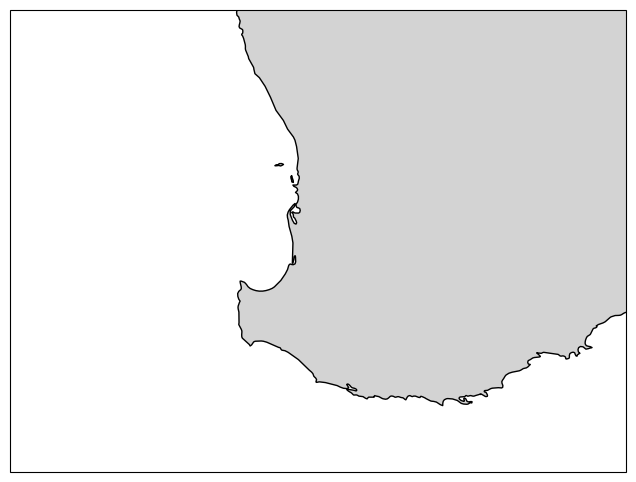

In [42]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Example SWWA box
lon_min, lon_max = 112, 120
lat_min, lat_max = -36, -30

fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(8, 6)
)

# Set extent to SWWA
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add Australian continent outline (from Natural Earth)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

# If you want land as a filled shape:
ax.add_feature(cfeature.LAND, facecolor="lightgrey")

plt.show()


ValueError: data type <class 'numpy.bool_'> not inexact

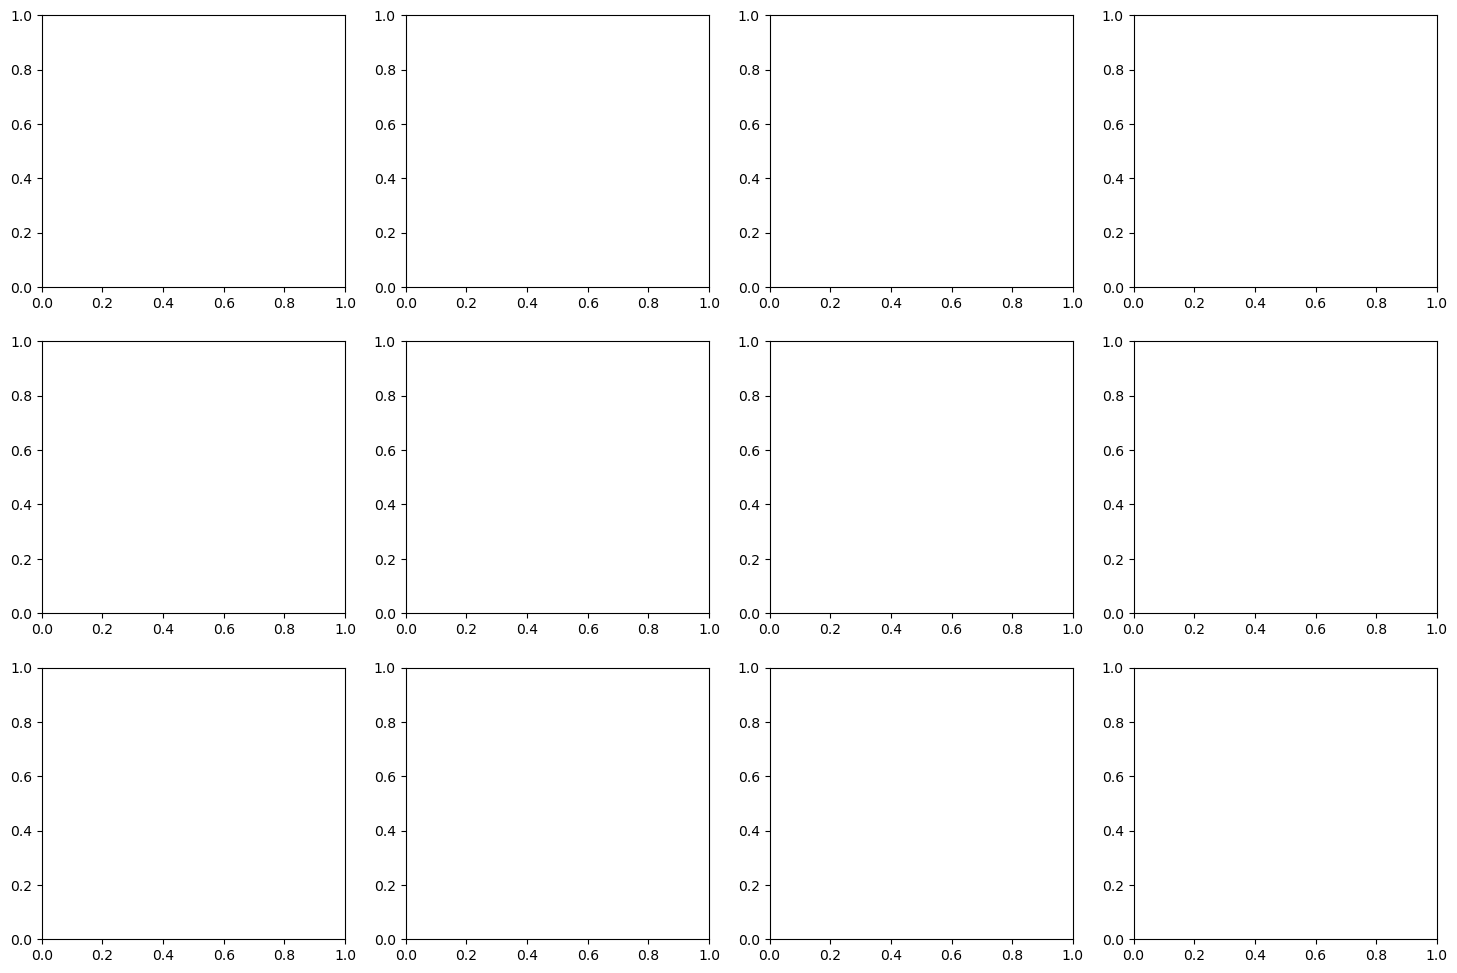

In [20]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import xarray as xr

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for m in range(1, 13):
    # --- Select month ---
    ffdi_m1 = ffdi_var_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=ffdi_var_old['time'].dt.month == m)
    ffdi_m2 = ffdi_var.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=ffdi_var['time'].dt.month == m)

    # --- Threshold mask ---
    ffdi_m1_50 = ffdi_m1 > 50
    ffdi_m2_50 = ffdi_m2 > 50

    # --- Frequency maps ---
    freq1 = ffdi_m1_50.sum(dim="time")
    freq2 = ffdi_m2_50.sum(dim="time")

    # --- Difference (new - old) ---
    diff = freq2 - freq1

    # --- Run t-test pixel by pixel ---
    pvals = xr.full_like(freq1, np.nan, dtype=float)
    for i in range(len(freq1.lat)):
        for j in range(len(freq1.lon)):
            ts1 = ffdi_m1_50[:, i, j].values
            ts2 = ffdi_m2_50[:, i, j].values
            if (~np.isnan(ts1).all()) and (~np.isnan(ts2).all()):
                stat, p = ttest_ind(ts1, ts2, equal_var=False, nan_policy="omit")
                pvals[i, j] = p

    # --- Plot diff map ---
    im = diff.plot(
        ax=axes[m-1],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-freq2.max().item(), vmax=freq2.max().item()
    )

     # --- Stipple significant areas (p < 0.05) ---
    sig = (pvals < 0.05).astype(float)  # convert bool → float
    axes[m-1].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],   # only plot where sig==1
        colors='none', hatches=['....'], alpha=0
    )

    axes[m-1].set_title(f"Month {m}")

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, label="Change in extreme FFDI days")

plt.suptitle("Change in Extreme FFDI Days (>50): 2005–2024 vs 1979–1998 (stippling = p<0.05)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()
